In [1]:
import os
import glob
import re
import datetime
from datetime import date, time, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

sns.set()

In [2]:
def parse_transcript(path):
    meeting_id = int(os.path.basename(os.path.dirname(path)))
    file_name = os.path.basename(path)
    file = re.search(r'^(?P<file>[A-Za-z0-9\-]+)_.*.vtt$', file_name).group('file')
    with open(path, 'r') as fh:
        while True:
            try:
                # ID
                m = None
                while m is None:
                    line = next(fh)
                    m = re.search(r'^(?P<id>\d+)\n?$', line)
                record = {'meeting_id': meeting_id, 'file': file, 'id': int(m.group('id'))}

                # Speak time details
                line = next(fh)
                m = re.search(r'^(?P<start>\d{2}:\d{2}:\d{2}.\d{3})\s+-+>\s+(?P<stop>\d{2}:\d{2}:\d{2}.\d{3})\n?$',
                              line)
                start = m.group('start')
                stop = m.group('stop')
                diff = datetime.datetime.strptime(stop, '%H:%M:%S.%f') - datetime.datetime.strptime(start, '%H:%M:%S.%f')
                spk_time = diff.total_seconds()
                record.update({'start': m.group('start'), 'stop': m.group('stop'), 'speak_time': spk_time})

                # Speaker and spoken word details
                line = next(fh)
                m = re.search(r'^((?P<speaker>[\w \t]+):)?(?P<text>.*)\n$', line)
                spkr = m.group('speaker')
                text = m.group('text')
                num_words = len([word for word in re.split(r'[\s\.,;]', m.group('text')) if word != ''])
                record.update({'speaker': spkr, 'text': text, 'num_words': num_words})

                yield record
            except StopIteration:
                break

In [3]:
def parse_participants(path):
    meeting_id = int(os.path.basename(os.path.dirname(path)))
    file_name = os.path.basename(path)
    file = re.search(r'^(?P<file>[\w\-]+).csv$', file_name).group('file')
    
    # Check if file has a related transcript
    # If not, don't parse
    transcript_filter = filter(lambda x: x.endswith('transcript.vtt'), os.listdir(os.path.dirname(path)))
    if len(list(transcript_filter)) > 0:
        with open(path, 'r') as fh:
            # Find where participant list starts
            line = None
            while line != '\n':
                line = next(fh)

            # Burn column row
            next(fh)

            # Get names (assumes name is first column for now)
            line = next(fh)
            while line != '\n':
                try:
                    name = line.split(',')[0]
                    yield {'meeting_id': meeting_id, 'file': file, 'participant': name}
                    line = next(fh)
                except StopIteration:
                    break

# Load Participants

In [14]:
ppaths = glob.glob('**/participants_*.csv', recursive=True)
ppaths

['zoom_data/83512718053/participants_83512718053.csv']

In [15]:
pchn = chain(*[parse_participants(pth) for pth in ppaths])
pdf = pd.DataFrame(pchn)
pdf

,meeting_id,file,participant
0,83512718053,participants_83512718053,Jack Cannon
1,83512718053,participants_83512718053,JoAnna Langberg


# Load Transcripts

In [16]:
paths = glob.glob('**/*.transcript.vtt', recursive=True)
paths

['zoom_data/83512718053/GMT20210527-002121_Recording.transcript.vtt']

In [17]:
chn = chain(*[parse_transcript(pth) for pth in paths])
df = pd.DataFrame(chn)
#df
df.drop(columns='file')

,meeting_id,id,start,stop,speak_time,speaker,text,num_words
0,83512718053,1,00:00:00.299,00:00:00.930,0.631,Jack Cannon,Here we go.,3
1,83512718053,2,00:00:09.690,00:00:10.290,0.600,Jack Cannon,One second.,2
2,83512718053,3,00:00:13.320,00:00:16.350,3.030,Jack Cannon,"When I did my presentation, the other day.",8
3,83512718053,4,00:00:17.789,00:00:20.280,2.491,Jack Cannon,I got to hit the share button.,7
4,83512718053,5,00:00:22.080,00:00:24.990,2.910,Jack Cannon,it's like you click share and then your monit...,11
...,...,...,...,...,...,...,...,...
281,83512718053,282,00:42:01.980,00:42:03.330,1.350,Jack Cannon,lot of material.,3
282,83512718053,283,00:42:04.860,00:42:06.210,1.350,Jack Cannon,For this next data set.,5
283,83512718053,284,00:42:09.420,00:42:10.890,1.470,Jack Cannon,So i'm going to stop sharing.,6
284,83512718053,285,00:42:13.530,00:42:14.400,0.870,JoAnna Langberg,or stop recording.,3


# Assign windows

In [18]:
def date_range(row):
    base = datetime.datetime.combine(date.today(), time.fromisoformat('00:00:00'))
    s = datetime.datetime.combine(date.today(), time.fromisoformat(row.start))
    e = datetime.datetime.combine(date.today(), time.fromisoformat(row.stop))
    exploded = pd.date_range(s, e, freq='S').union([e])
    tot_sec = (exploded - base).total_seconds()

    return tot_sec.to_numpy()

In [19]:
window_len = 300
df2 = df.loc[:, ['meeting_id', 'file', 'id', 'start', 'stop']]
df2['elapsed'] = df2.apply(date_range, axis=1)
df2 = df2.explode('elapsed')
df2['window'] = (df2.elapsed // window_len + 1).astype(int) * window_len
df2['window_time'] = df2.groupby(['meeting_id', 'file', 'id', 'window']).elapsed.diff()
df2.dropna(inplace=True)
df2 = df2.groupby(['meeting_id', 'file', 'id', 'window'], as_index=False) \
         .window_time \
         .sum()
df2

,meeting_id,file,id,window,window_time
0,83512718053,GMT20210527-002121,1,300,0.631
1,83512718053,GMT20210527-002121,2,300,0.600
2,83512718053,GMT20210527-002121,3,300,3.030
3,83512718053,GMT20210527-002121,4,300,2.491
4,83512718053,GMT20210527-002121,5,300,2.910
...,...,...,...,...,...
288,83512718053,GMT20210527-002121,282,2700,1.350
289,83512718053,GMT20210527-002121,283,2700,1.350
290,83512718053,GMT20210527-002121,284,2700,1.470
291,83512718053,GMT20210527-002121,285,2700,0.870


In [20]:
df = df.merge(df2, on=['meeting_id', 'file', 'id'], how='left')
#df
df.drop(columns='file')

,meeting_id,id,start,stop,speak_time,speaker,text,num_words,window,window_time
0,83512718053,1,00:00:00.299,00:00:00.930,0.631,Jack Cannon,Here we go.,3,300,0.631
1,83512718053,2,00:00:09.690,00:00:10.290,0.600,Jack Cannon,One second.,2,300,0.600
2,83512718053,3,00:00:13.320,00:00:16.350,3.030,Jack Cannon,"When I did my presentation, the other day.",8,300,3.030
3,83512718053,4,00:00:17.789,00:00:20.280,2.491,Jack Cannon,I got to hit the share button.,7,300,2.491
4,83512718053,5,00:00:22.080,00:00:24.990,2.910,Jack Cannon,it's like you click share and then your monit...,11,300,2.910
...,...,...,...,...,...,...,...,...,...,...
288,83512718053,282,00:42:01.980,00:42:03.330,1.350,Jack Cannon,lot of material.,3,2700,1.350
289,83512718053,283,00:42:04.860,00:42:06.210,1.350,Jack Cannon,For this next data set.,5,2700,1.350
290,83512718053,284,00:42:09.420,00:42:10.890,1.470,Jack Cannon,So i'm going to stop sharing.,6,2700,1.470
291,83512718053,285,00:42:13.530,00:42:14.400,0.870,JoAnna Langberg,or stop recording.,3,2700,0.870


# Avg Utterance Length

In [21]:
ut_len = df.loc[:, ['meeting_id', 'file', 'id', 'speaker', 'speak_time']] \
           .drop_duplicates(ignore_index=True) \
           .groupby(['meeting_id', 'speaker'], as_index=False) \
           .speak_time \
           .median() \
           .sort_values(['meeting_id', 'speak_time'], ascending=False, ignore_index=True)
ut_len

,meeting_id,speaker,speak_time
0,83512718053,Jack Cannon,8.25
1,83512718053,JoAnna Langberg,1.92


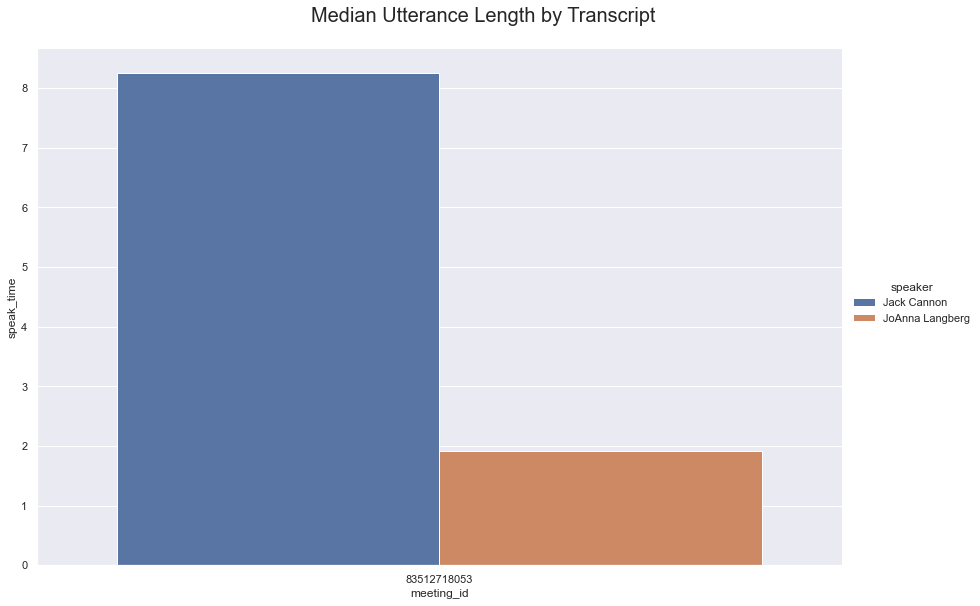

In [22]:
g = sns.catplot(data=ut_len, kind='bar', x='meeting_id', y='speak_time', hue='speaker', height=8, aspect=1.5)
g.fig.suptitle('Median Utterance Length by Transcript', size=20, y=1.05);

In [23]:
def plot_ut(data, **kwargs):
    cmap = kwargs.pop('cmap')
    color = kwargs.pop('color')
    ax = plt.gca()
    sns.barplot(data=data.sort_values(['meeting_id', 'speak_time'], ascending=False, ignore_index=True),
                ax=ax, palette=[cmap[name] for name in data[kwargs['x']].unique()], **kwargs)

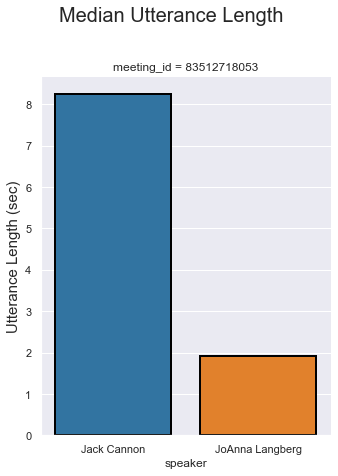

In [24]:
cmap = {name: c for name, c in zip(ut_len.speaker.unique(), sns.color_palette('tab10'))}
g = sns.FacetGrid(data=ut_len, col='meeting_id', height=6, aspect=0.8, sharex=False, sharey=True)
g.map_dataframe(plot_ut, x='speaker', y='speak_time', cmap=cmap, linewidth=2, edgecolor='black')
g.axes.flatten()[0].set_ylabel("Utterance Length (sec)", size=15)
#g.fig.suptitle('Median Utterance Length by Meeting ID', size=20, y=1.1);
g.fig.suptitle('Median Utterance Length', size=20, y=1.1);

In [25]:
def plot_ut(data, **kwargs):
    #color = kwargs.pop('color')
    ax = plt.gca()
    sns.barplot(data=data.sort_values(['meeting_id', 'speak_time'], ascending=False, ignore_index=True),
                ax=ax, **kwargs)

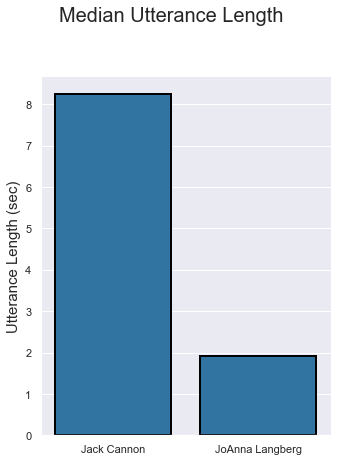

In [26]:
#cmap = {name: c for name, c in zip(ut_len.speaker.unique(), sns.color_palette('tab10'))}
g = sns.FacetGrid(data=ut_len, col='meeting_id', height=6, aspect=0.8, sharex=False, sharey=True)
g.map_dataframe(plot_ut, x='speaker', y='speak_time', color=sns.color_palette('tab10')[0], linewidth=2, edgecolor='black')
g.axes.flatten()[0].set_ylabel("Utterance Length (sec)", size=15)
g.axes.flatten()[0].set_xlabel("")
g.axes.flatten()[0].set_title("")
#g.fig.suptitle('Median Utterance Length by Meeting ID', size=20, y=1.1);
g.fig.suptitle('Median Utterance Length', size=20, y=1.1);

# Proportion Speaking Time

In [27]:
spk_time = df.loc[:, ['meeting_id', 'file', 'id', 'speak_time', 'speaker']] \
             .drop_duplicates(ignore_index=True) \
             .groupby(['meeting_id', 'file', 'speaker'], as_index=False) \
             .speak_time \
             .sum()
spk_time['meeting_time'] = spk_time.groupby('meeting_id', as_index=False) \
                                   .speak_time \
                                   .transform(sum)
spk_time['speak_pct'] = spk_time.speak_time / spk_time.meeting_time
spk_time

,meeting_id,file,speaker,speak_time,meeting_time,speak_pct
0,83512718053,GMT20210527-002121,Jack Cannon,2103.362,2190.722,0.960123
1,83512718053,GMT20210527-002121,JoAnna Langberg,87.360,2190.722,0.039877


In [28]:
def plot_donut(data, **kwargs):
    cmap = kwargs.pop('cmap')
    color = kwargs.pop('color')
    x = data[kwargs.pop('x')]
    labels = data[kwargs.pop('labels')]
    
    ax = plt.gca()
    ax.pie(x=x, labels=labels, colors=[cmap[name] for name in labels], **kwargs)
    ax.add_artist(plt.Circle((0, 0), 0.75, fc='white'))       

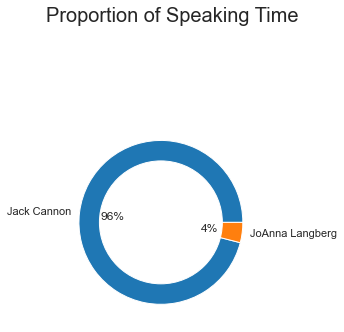

In [29]:
g = sns.FacetGrid(data=spk_time, col='meeting_id', height=6, aspect=0.8, despine=False)
g.map_dataframe(plot_donut, x='speak_time', labels='speaker', autopct="%0.f%%", cmap=cmap)
g.axes.flatten()[0].set_xlabel("")
g.axes.flatten()[0].set_title("")
#g.fig.suptitle('Speaking Proportion by Meeting ID', size=20, y=1);
g.fig.suptitle('Proportion of Speaking Time', size=20, y=1);

# Who Didn't Speak Up?
Uses speaking time data from above step

In [30]:
spk_time

,meeting_id,file,speaker,speak_time,meeting_time,speak_pct
0,83512718053,GMT20210527-002121,Jack Cannon,2103.362,2190.722,0.960123
1,83512718053,GMT20210527-002121,JoAnna Langberg,87.360,2190.722,0.039877


In [31]:
pdf

,meeting_id,file,participant
0,83512718053,participants_83512718053,Jack Cannon
1,83512718053,participants_83512718053,JoAnna Langberg


Test functionality when someone didn't speak

In [32]:
spk_time2 = spk_time.query("speaker != 'Thao Tran'")
spk_time2

,meeting_id,file,speaker,speak_time,meeting_time,speak_pct
0,83512718053,GMT20210527-002121,Jack Cannon,2103.362,2190.722,0.960123
1,83512718053,GMT20210527-002121,JoAnna Langberg,87.360,2190.722,0.039877


In [33]:
no_spk = pdf[['meeting_id', 'participant']].merge(spk_time2[['meeting_id', 'speaker']], 
                                                   how='left', 
                                                   left_on=['meeting_id', 'participant'], 
                                                   right_on=['meeting_id', 'speaker'])
no_spk

,meeting_id,participant,speaker
0,83512718053,Jack Cannon,Jack Cannon
1,83512718053,JoAnna Langberg,JoAnna Langberg


### Calculate % of those who spoke up

In [34]:
no_spk.groupby('meeting_id') \
      .speaker \
      .apply(lambda x: 1 - (x.isna().sum() / x.size))

meeting_id
83512718053    1.0
Name: speaker, dtype: float64

### Get list of non-speakers

In [35]:
no_spk.query("speaker.isna()")[['meeting_id', 'participant']]

TypeError: unhashable type: 'Series'

# Window Analysis

In [36]:
windows = df.groupby(['meeting_id', 'file', 'speaker', 'window'], as_index=False) \
            .window_time \
            .sum()
windows

,meeting_id,file,speaker,window,window_time
0,83512718053,GMT20210527-002121,Jack Cannon,300,233.702
1,83512718053,GMT20210527-002121,Jack Cannon,600,239.460
2,83512718053,GMT20210527-002121,Jack Cannon,900,254.670
3,83512718053,GMT20210527-002121,Jack Cannon,1200,251.620
4,83512718053,GMT20210527-002121,Jack Cannon,1500,254.130
5,83512718053,GMT20210527-002121,Jack Cannon,1800,249.150
6,83512718053,GMT20210527-002121,Jack Cannon,2100,262.120
7,83512718053,GMT20210527-002121,Jack Cannon,2400,269.740
8,83512718053,GMT20210527-002121,Jack Cannon,2700,81.770
9,83512718053,GMT20210527-002121,JoAnna Langberg,300,3.720


In [37]:
def plot_windows(data, **kwargs):
    cmap = kwargs.pop('cmap')
    color = kwargs.pop('color')
    width = kwargs.pop('width')
    ax = plt.gca()
    windows = data.window.unique()
    x_labs = np.arange(windows.size)
    last = pd.Series([0] * windows.size, index=windows)
    for grp, d in data.groupby('speaker'):
        window = d.window
        window_time = d.window_time
        if d.window.size != len(x_labs):
            window_time = pd.Series(window_time.tolist(), index=d.window).reindex(windows, fill_value=0)
            window = window_time.index.to_numpy()
        ax.bar(x_labs, window_time, width, bottom=last, label=grp, color=cmap[grp], **kwargs)
        last = last + pd.Series(window_time.to_numpy(), index=window)
        last.fillna(0, inplace=True)
    ax.set_xticks(x_labs)
    ax.set_xticklabels(data.window.unique())

/Users/jackcan/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


"\ng.axes[2].set_ylabel('Speaking Time', size=15)\ng.axes[4].set_ylabel('Speaking Time', size=15)\n#g.axes[2].set_xlabel('Window (sec)', size=15)\ng.axes[4].set_xlabel('Window (sec)', size=15)\ng.fig.suptitle('Speaking Pace over Time by Meeting ID', size=30, y=1.1);\n"

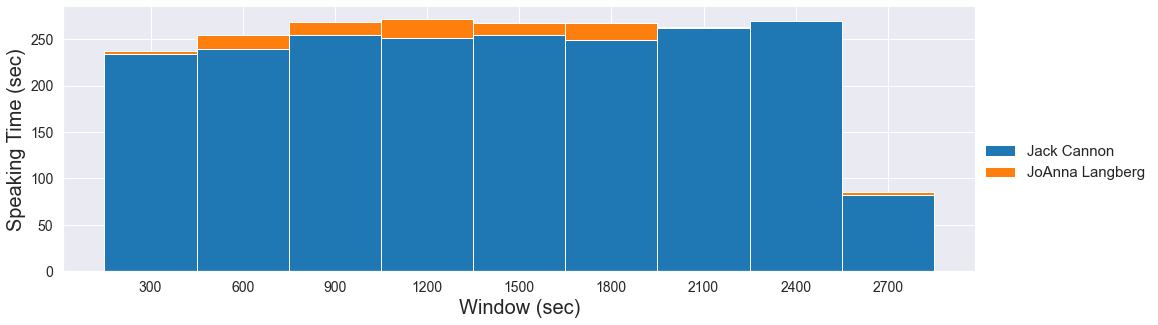

In [38]:
g = sns.FacetGrid(data=windows, col='meeting_id', height=4.5, aspect=3, sharex=False, sharey=False)
g.map_dataframe(plot_windows, cmap=cmap, width=1)
g.add_legend(adjust_subtitles=True, fontsize=15)
#g.axes[0].set_ylabel('Speaking Time', size=15)
g.axes[0][0].set_title('')
g.axes[0][0].set_ylabel('Speaking Time (sec)', size=20)
g.axes[0][0].set_xlabel('Window (sec)', size=20)
g.axes[0][0].set_xticklabels(g.axes[0][0].get_xticklabels(), size=14)
g.axes[0][0].set_yticklabels(g.axes[0][0].get_yticklabels(), size=14)
'''
g.axes[2].set_ylabel('Speaking Time', size=15)
g.axes[4].set_ylabel('Speaking Time', size=15)
#g.axes[2].set_xlabel('Window (sec)', size=15)
g.axes[4].set_xlabel('Window (sec)', size=15)
g.fig.suptitle('Speaking Pace over Time by Meeting ID', size=30, y=1.1);
'''
#g.fig.suptitle('Speaking Pace over Time by Meeting ID', size=30, y=1.1);

In [24]:
g.axes

array([[<AxesSubplot:title={'center':'meeting_id = 83512718053'}>]],
      dtype=object)

# Sentiment Analysis

### Prep Models

In [39]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from functools import partial
import torch

candidate_labels = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']
models = {
    'zero-shot-classification': ['facebook/bart-large-mnli', 
                                 'typeform/distilbert-base-uncased-mnli'],
    'sentiment-analysis': ['distilbert-base-uncased-finetuned-sst-2-english', 
                           'nlptown/bert-base-multilingual-uncased-sentiment', 
                           'ProsusAI/finbert']
}

#classifiers = []
classifiers = {}
kwargs = {'return_all_scores': True}
for tag, ms in models.items():
    for m in ms:
        print(f'Downloading {m}')
        if tag == 'sentiment-analysis':
            clf = pipeline(tag, model=m, **kwargs)
        else:
            clf = partial(pipeline(tag, model=m), candidate_labels=candidate_labels)
        #classifiers.append({'tag': tag, 'model': m, 'clf': clf})
        classifiers.update({m: {'tag': tag, 'clf': clf}})
#classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
#classifier = pipeline("zero-shot-classification", model='typeform/distilbert-base-uncased-mnli')
#classifier2 = pipeline('sentiment-analysis', return_all_scores=True)
#classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment', return_all_scores=False)
#classifier = pipeline('sentiment-analysis', model='ProsusAI/finbert', return_all_scores=True)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [40]:
def parse_zshot(clf, model, sequences):      
    results = clf(sequences)
    if not isinstance(results, list):
        results = [results]
    
    out = []
    for i, r in enumerate(results):
        for l, s in zip(r['labels'], r['scores']):
            out.append({'idx': i, 'seq': r['sequence'], 'model': model, 'granularity': 'binary', 'label': l, 'score': s})
        
    return out

In [41]:
def parse_sentiment(clf, model, sequences):      
    results = clf(sequences)
    if not isinstance(results, list):
        results = [results]
    
    granularity = 'binary' 
    if model == 'nlptown/bert-base-multilingual-uncased-sentiment':
        granularity = 'stars'
        
    out = []
    for i, (seq, r) in enumerate(zip(sequences, results)):
        for score in r:
            out.append({'idx': i, 'seq': seq, 'model': model, 'granularity': granularity, 'label': score['label'].upper(), 'score': score['score']})
        
    return out

In [42]:
dispatch = {'zero-shot-classification': parse_zshot,
            'sentiment-analysis': parse_sentiment}

### Evaluate on test sentences

In [43]:
seq = ["Hello! How are you?",
       "I hate you!",
       "I love you!",
       "This class sucks"]

In [44]:
data = []
for model, meta in classifiers.items():
    clf = meta['clf']
    data.extend(dispatch[meta['tag']](clf, model, seq))
sentiment_df = pd.DataFrame(data)

In [45]:
sentiment_df

,idx,seq,model,granularity,label,score
0,0,Hello! How are you?,facebook/bart-large-mnli,binary,POSITIVE,0.543251
1,0,Hello! How are you?,facebook/bart-large-mnli,binary,NEUTRAL,0.286172
2,0,Hello! How are you?,facebook/bart-large-mnli,binary,NEGATIVE,0.170577
3,1,I hate you!,facebook/bart-large-mnli,binary,NEGATIVE,0.766882
4,1,I hate you!,facebook/bart-large-mnli,binary,NEUTRAL,0.195743
...,...,...,...,...,...,...
59,2,I love you!,ProsusAI/finbert,binary,NEGATIVE,0.027157
60,2,I love you!,ProsusAI/finbert,binary,NEUTRAL,0.823611
61,3,This class sucks,ProsusAI/finbert,binary,POSITIVE,0.045176
62,3,This class sucks,ProsusAI/finbert,binary,NEGATIVE,0.028824


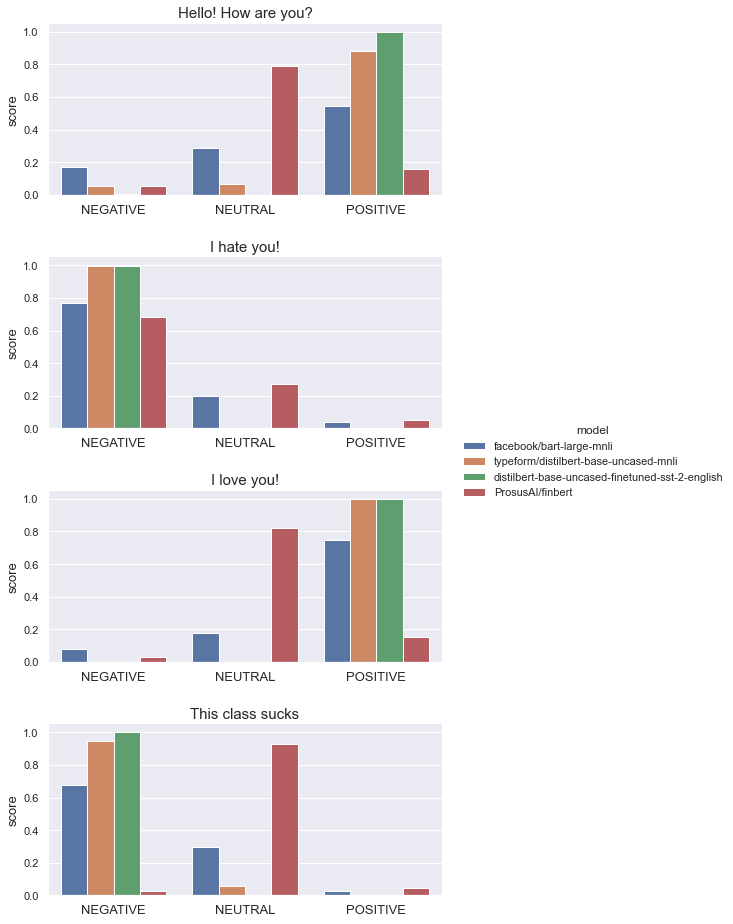

In [48]:
g = sns.catplot(data=sentiment_df.query("granularity == 'binary'"), x='label', y='score',
                kind='bar', hue='model', row='seq', margin_titles=False, 
                order=["NEGATIVE", "NEUTRAL", "POSITIVE"], 
                height=3.25, aspect=2,
                sharex=False,
                legend_out=True)
(g.set_titles(row_template="{row_name}"))
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=15)
    ax.set_ylabel(ax.get_ylabel(), fontsize=13)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
g.tight_layout(h_pad=2);
plt.savefig("thesis/mscs_thesis/figures/2_2_1_sm_eval.pdf", dpi=300)

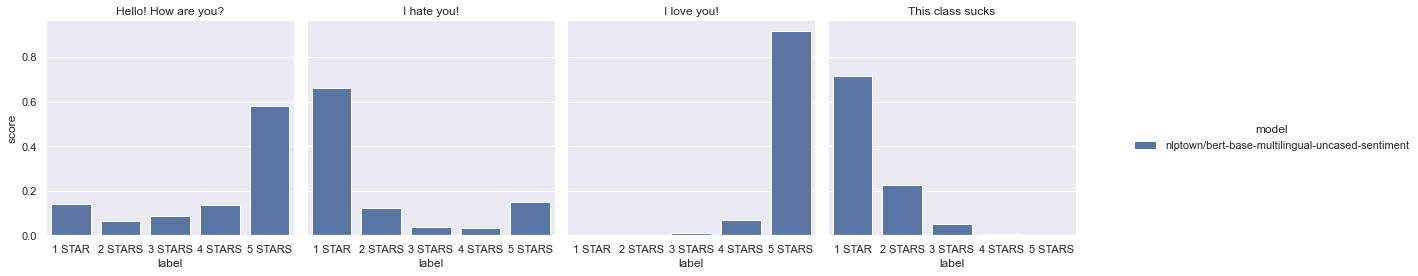

In [101]:
g = sns.catplot(data=sentiment_df.query("granularity == 'stars'"), x='label', y='score',
                kind='bar', hue='model',
                col='seq', margin_titles=True, order=["1 STAR", "2 STARS", "3 STARS", "4 STARS", "5 STARS"], 
                height=4, aspect=1)
(g.set_titles(col_template="{col_name}"));

### Pick a model and run on dataset

In [102]:
sequences = df.text.to_list()

In [103]:
model_type = classifiers['facebook/bart-large-mnli']['tag']
clf = classifiers['facebook/bart-large-mnli']['clf']

In [49]:
results = clf(sequences)
if not isinstance(results, list):
    results = [results]

In [50]:
results

[{'sequence': ' Here we go.',
  'labels': ['POSITIVE', 'NEUTRAL', 'NEGATIVE'],
  'scores': [0.591551661491394, 0.21647074818611145, 0.1919776201248169]},
 {'sequence': ' One second.',
  'labels': ['NEUTRAL', 'NEGATIVE', 'POSITIVE'],
  'scores': [0.3542611598968506, 0.34533801674842834, 0.30040085315704346]},
 {'sequence': ' When I did my presentation, the other day.',
  'labels': ['POSITIVE', 'NEUTRAL', 'NEGATIVE'],
  'scores': [0.5422729253768921, 0.2521163523197174, 0.20561066269874573]},
 {'sequence': ' I got to hit the share button.',
  'labels': ['POSITIVE', 'NEUTRAL', 'NEGATIVE'],
  'scores': [0.6153314709663391, 0.21258480846881866, 0.17208370566368103]},
 {'sequence': " it's like you click share and then your monitors come up.",
  'labels': ['POSITIVE', 'NEUTRAL', 'NEGATIVE'],
  'scores': [0.45632511377334595, 0.31271299719810486, 0.2309618890285492]},
 {'sequence': ' And you sleep like order is.',
  'labels': ['POSITIVE', 'NEUTRAL', 'NEGATIVE'],
  'scores': [0.4815281629562378

In [49]:
results = dispatch[meta['tag']](clf, model_type, sequences)

KeyboardInterrupt: 

In [113]:
out = []
for i, r in enumerate(results):
    for l, s in zip(r['labels'], r['scores']):
        out.append({'idx': i, 'seq': r['sequence'], 'model': model, 'granularity': 'binary', 'label': l, 'score': s})

In [114]:
out

[{'idx': 0,
  'seq': ' Here we go.',
  'model': 'typeform/distilbert-base-uncased-mnli',
  'granularity': 'binary',
  'sentiment': 'POSITIVE',
  'score': 0.591551661491394},
 {'idx': 0,
  'seq': ' Here we go.',
  'model': 'typeform/distilbert-base-uncased-mnli',
  'granularity': 'binary',
  'sentiment': 'NEUTRAL',
  'score': 0.21647074818611145},
 {'idx': 0,
  'seq': ' Here we go.',
  'model': 'typeform/distilbert-base-uncased-mnli',
  'granularity': 'binary',
  'sentiment': 'NEGATIVE',
  'score': 0.1919776201248169},
 {'idx': 1,
  'seq': ' One second.',
  'model': 'typeform/distilbert-base-uncased-mnli',
  'granularity': 'binary',
  'sentiment': 'NEUTRAL',
  'score': 0.3542611598968506},
 {'idx': 1,
  'seq': ' One second.',
  'model': 'typeform/distilbert-base-uncased-mnli',
  'granularity': 'binary',
  'sentiment': 'NEGATIVE',
  'score': 0.34533801674842834},
 {'idx': 1,
  'seq': ' One second.',
  'model': 'typeform/distilbert-base-uncased-mnli',
  'granularity': 'binary',
  'sentime

In [104]:
data = []
for model, meta in classifiers.items():
    clf = meta['clf']
    data.extend(dispatch[meta['tag']](clf, model, sequences))
sentiment_df = pd.DataFrame(data)

In [105]:
sentiment_df

,idx,seq,model,granularity,label,score
0,0,Here we go.,facebook/bart-large-mnli,binary,POSITIVE,0.591552
1,0,Here we go.,facebook/bart-large-mnli,binary,NEUTRAL,0.216471
2,0,Here we go.,facebook/bart-large-mnli,binary,NEGATIVE,0.191978
3,1,One second.,facebook/bart-large-mnli,binary,NEUTRAL,0.354261
4,1,One second.,facebook/bart-large-mnli,binary,NEGATIVE,0.345338
...,...,...,...,...,...,...
4683,291,or stop recording.,ProsusAI/finbert,binary,NEGATIVE,0.092247
4684,291,or stop recording.,ProsusAI/finbert,binary,NEUTRAL,0.884906
4685,292,Start recording it was just testing you.,ProsusAI/finbert,binary,POSITIVE,0.035787
4686,292,Start recording it was just testing you.,ProsusAI/finbert,binary,NEGATIVE,0.104696


In [106]:
sentiment_df.query('idx == 0')

,idx,seq,model,granularity,label,score
0,0,Here we go.,facebook/bart-large-mnli,binary,POSITIVE,0.591552
1,0,Here we go.,facebook/bart-large-mnli,binary,NEUTRAL,0.216471
2,0,Here we go.,facebook/bart-large-mnli,binary,NEGATIVE,0.191978
879,0,Here we go.,typeform/distilbert-base-uncased-mnli,binary,POSITIVE,0.461708
880,0,Here we go.,typeform/distilbert-base-uncased-mnli,binary,NEGATIVE,0.384784
881,0,Here we go.,typeform/distilbert-base-uncased-mnli,binary,NEUTRAL,0.153508
1758,0,Here we go.,distilbert-base-uncased-finetuned-sst-2-english,binary,NEGATIVE,0.001168
1759,0,Here we go.,distilbert-base-uncased-finetuned-sst-2-english,binary,POSITIVE,0.998832
2344,0,Here we go.,nlptown/bert-base-multilingual-uncased-sentiment,stars,1 STAR,0.049190
2345,0,Here we go.,nlptown/bert-base-multilingual-uncased-sentiment,stars,2 STARS,0.041656


In [86]:
df

,meeting_id,file,id,start,stop,speak_time,speaker,text,num_words,window,window_time
0,87910349045,GMT20210202-000205,1,00:00:04.380,00:00:14.130,9.75,Jack Cannon,"Okay, so I think this may not take very long,...",42,300,9.75
1,87910349045,GMT20210202-000205,2,00:00:17.250,00:00:23.820,6.57,Jack Cannon,"So I am getting some results, and I just kind...",19,300,6.57
2,87910349045,GMT20210202-000205,3,00:00:24.240,00:00:31.710,7.47,Jack Cannon,"Okay, because if i'm doing something wrong, I...",25,300,7.47
3,87910349045,GMT20210202-000205,4,00:00:32.910,00:00:34.170,1.26,suresh singh,i'm not seeing anything.,4,300,1.26
4,87910349045,GMT20210202-000205,5,00:00:34.350,00:00:36.210,1.86,Jack Cannon,Or did I not share okay let's see.,8,300,1.86
...,...,...,...,...,...,...,...,...,...,...,...
958,89320106852,GMT20210202-021531,298,00:30:27.150,00:30:30.990,3.84,Jack Cannon,Enabling annotation for meetings.,4,2100,3.84
959,89320106852,GMT20210202-021531,299,00:30:32.940,00:30:40.440,7.50,Jack Cannon,let's see what this says prerequisites and zo...,19,2100,7.50
960,89320106852,GMT20210202-021531,300,00:30:58.470,00:31:07.410,8.94,Jack Cannon,hey let's uh let me get off this let's get of...,37,2100,8.94
961,89320106852,GMT20210202-021531,301,00:31:08.340,00:31:09.630,1.29,JoAnna Langberg,"Okay, do you think it's gonna be like a minute.",10,2100,1.29


In [107]:
model = 'typeform/distilbert-base-uncased-mnli'
sentiment_df2 = sentiment_df.query("model == @model") \
                            .sort_values(['idx', 'score'], ascending=[True, False]) \
                            .drop_duplicates(subset='idx', keep='first') \
                            .set_index('idx')

In [108]:
sentiment_df.query("model == @model")

,idx,seq,model,granularity,label,score
879,0,Here we go.,typeform/distilbert-base-uncased-mnli,binary,POSITIVE,0.461708
880,0,Here we go.,typeform/distilbert-base-uncased-mnli,binary,NEGATIVE,0.384784
881,0,Here we go.,typeform/distilbert-base-uncased-mnli,binary,NEUTRAL,0.153508
882,1,One second.,typeform/distilbert-base-uncased-mnli,binary,NEGATIVE,0.381538
883,1,One second.,typeform/distilbert-base-uncased-mnli,binary,POSITIVE,0.345879
...,...,...,...,...,...,...
1753,291,or stop recording.,typeform/distilbert-base-uncased-mnli,binary,POSITIVE,0.334242
1754,291,or stop recording.,typeform/distilbert-base-uncased-mnli,binary,NEUTRAL,0.297251
1755,292,Start recording it was just testing you.,typeform/distilbert-base-uncased-mnli,binary,NEGATIVE,0.519143
1756,292,Start recording it was just testing you.,typeform/distilbert-base-uncased-mnli,binary,POSITIVE,0.372827


In [103]:
sentiment_df2

,seq,model,granularity,label,score
idx,,,,,
0,Here we go.,typeform/distilbert-base-uncased-mnli,binary,POSITIVE,0.461708
1,One second.,typeform/distilbert-base-uncased-mnli,binary,NEGATIVE,0.381538
2,"When I did my presentation, the other day.",typeform/distilbert-base-uncased-mnli,binary,POSITIVE,0.401223
3,I got to hit the share button.,typeform/distilbert-base-uncased-mnli,binary,POSITIVE,0.659739
4,it's like you click share and then your monit...,typeform/distilbert-base-uncased-mnli,binary,POSITIVE,0.475190
...,...,...,...,...,...
288,lot of material.,typeform/distilbert-base-uncased-mnli,binary,NEGATIVE,0.451246
289,For this next data set.,typeform/distilbert-base-uncased-mnli,binary,POSITIVE,0.571632
290,So i'm going to stop sharing.,typeform/distilbert-base-uncased-mnli,binary,NEGATIVE,0.949988


In [109]:
data = df[['meeting_id', 'speaker', 'speak_time', 'num_words']].join(sentiment_df2[['label', 'score']])
data['sentiment_pct'] = data.speak_time / data.groupby('speaker').speak_time.transform(sum)
data

,meeting_id,speaker,speak_time,num_words,label,score,sentiment_pct
0,83512718053,Jack Cannon,0.631,3,POSITIVE,0.461708,0.000290
1,83512718053,Jack Cannon,0.600,2,NEGATIVE,0.381538,0.000276
2,83512718053,Jack Cannon,3.030,8,POSITIVE,0.401223,0.001394
3,83512718053,Jack Cannon,2.491,7,POSITIVE,0.659739,0.001146
4,83512718053,Jack Cannon,2.910,11,POSITIVE,0.475190,0.001338
...,...,...,...,...,...,...,...
288,83512718053,Jack Cannon,1.350,3,NEGATIVE,0.451246,0.000621
289,83512718053,Jack Cannon,1.350,5,POSITIVE,0.571632,0.000621
290,83512718053,Jack Cannon,1.470,6,NEGATIVE,0.949988,0.000676
291,83512718053,JoAnna Langberg,0.870,3,NEGATIVE,0.368508,0.009959


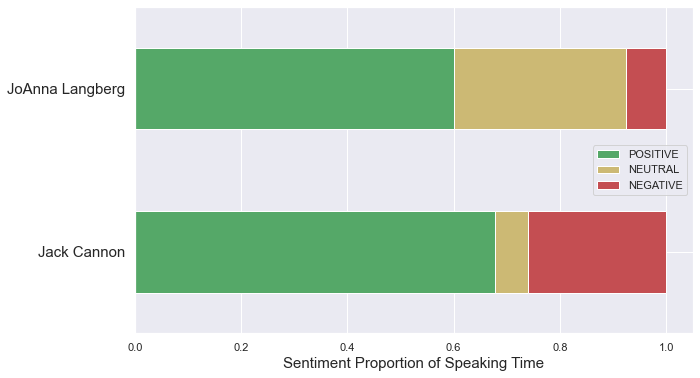

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
data.groupby(['speaker', 'label'], as_index=False) \
    .sentiment_pct \
    .sum() \
    .pivot(index=['speaker'], columns='label', values='sentiment_pct') \
    .reindex(columns=['POSITIVE', 'NEUTRAL', 'NEGATIVE']) \
    .plot \
    .barh(stacked=True,
          ax=ax,
          color={'POSITIVE': 'g', 'NEGATIVE': 'r', 'NEUTRAL': 'y'}, 
          legend=False)
ax.set_ylabel("")
ax.set_xlabel("Sentiment Proportion of Speaking Time", size=15)
ax.set_yticklabels(ax.get_yticklabels(), size=15)
ax.legend()
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, ncol=3, loc='upper center');
#fig.legend(handles, labels, ncol=1, loc='best');

In [109]:
data

,meeting_id,speaker,speak_time,num_words,label,score,sentiment_pct
0,83512718053,Jack Cannon,0.631,3,POSITIVE,0.461708,0.000290
1,83512718053,Jack Cannon,0.600,2,NEGATIVE,0.381538,0.000276
2,83512718053,Jack Cannon,3.030,8,POSITIVE,0.401223,0.001394
3,83512718053,Jack Cannon,2.491,7,POSITIVE,0.659739,0.001146
4,83512718053,Jack Cannon,2.910,11,POSITIVE,0.475190,0.001338
...,...,...,...,...,...,...,...
288,83512718053,Jack Cannon,1.350,3,NEGATIVE,0.451246,0.000621
289,83512718053,Jack Cannon,1.350,5,POSITIVE,0.571632,0.000621
290,83512718053,Jack Cannon,1.470,6,NEGATIVE,0.949988,0.000676
291,83512718053,JoAnna Langberg,0.870,3,NEGATIVE,0.368508,0.009959


In [107]:
df

,meeting_id,file,id,start,stop,speak_time,speaker,text,num_words,window,window_time
0,83512718053,GMT20210527-002121,1,00:00:00.299,00:00:00.930,0.631,Jack Cannon,Here we go.,3,300,0.631
1,83512718053,GMT20210527-002121,2,00:00:09.690,00:00:10.290,0.600,Jack Cannon,One second.,2,300,0.600
2,83512718053,GMT20210527-002121,3,00:00:13.320,00:00:16.350,3.030,Jack Cannon,"When I did my presentation, the other day.",8,300,3.030
3,83512718053,GMT20210527-002121,4,00:00:17.789,00:00:20.280,2.491,Jack Cannon,I got to hit the share button.,7,300,2.491
4,83512718053,GMT20210527-002121,5,00:00:22.080,00:00:24.990,2.910,Jack Cannon,it's like you click share and then your monit...,11,300,2.910
...,...,...,...,...,...,...,...,...,...,...,...
288,83512718053,GMT20210527-002121,282,00:42:01.980,00:42:03.330,1.350,Jack Cannon,lot of material.,3,2700,1.350
289,83512718053,GMT20210527-002121,283,00:42:04.860,00:42:06.210,1.350,Jack Cannon,For this next data set.,5,2700,1.350
290,83512718053,GMT20210527-002121,284,00:42:09.420,00:42:10.890,1.470,Jack Cannon,So i'm going to stop sharing.,6,2700,1.470
291,83512718053,GMT20210527-002121,285,00:42:13.530,00:42:14.400,0.870,JoAnna Langberg,or stop recording.,3,2700,0.870


In [116]:
df.merge(data[['label']], how='left', left_index=True, right_index=True) \
  .rename(columns={'label': 'sentiment'}) \
  .drop(columns='file')

,meeting_id,id,start,stop,speak_time,speaker,text,num_words,window,window_time,sentiment
0,83512718053,1,00:00:00.299,00:00:00.930,0.631,Jack Cannon,Here we go.,3,300,0.631,POSITIVE
1,83512718053,2,00:00:09.690,00:00:10.290,0.600,Jack Cannon,One second.,2,300,0.600,NEGATIVE
2,83512718053,3,00:00:13.320,00:00:16.350,3.030,Jack Cannon,"When I did my presentation, the other day.",8,300,3.030,POSITIVE
3,83512718053,4,00:00:17.789,00:00:20.280,2.491,Jack Cannon,I got to hit the share button.,7,300,2.491,POSITIVE
4,83512718053,5,00:00:22.080,00:00:24.990,2.910,Jack Cannon,it's like you click share and then your monit...,11,300,2.910,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...
288,83512718053,282,00:42:01.980,00:42:03.330,1.350,Jack Cannon,lot of material.,3,2700,1.350,NEGATIVE
289,83512718053,283,00:42:04.860,00:42:06.210,1.350,Jack Cannon,For this next data set.,5,2700,1.350,POSITIVE
290,83512718053,284,00:42:09.420,00:42:10.890,1.470,Jack Cannon,So i'm going to stop sharing.,6,2700,1.470,NEGATIVE
291,83512718053,285,00:42:13.530,00:42:14.400,0.870,JoAnna Langberg,or stop recording.,3,2700,0.870,NEGATIVE


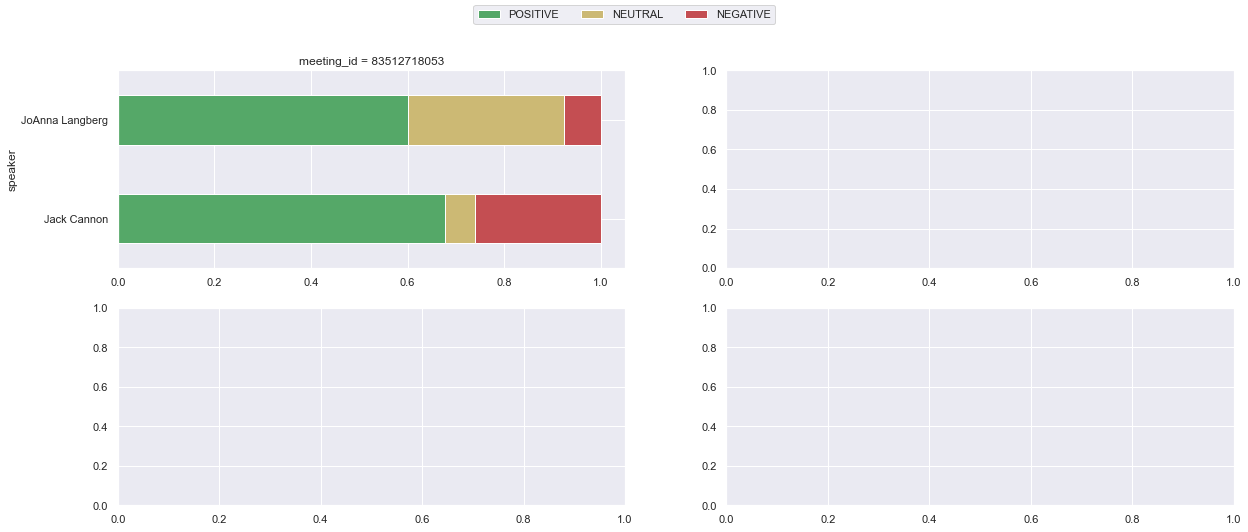

In [111]:
fig, ax = plt.subplots(2, 2, figsize=(20, 8))
for a, (grp, data) in zip(ax.flatten(), df[['meeting_id', 'speaker', 'speak_time', 'num_words']].join(sentiment_df2[['label', 'score']]).groupby('meeting_id')):
    data['sentiment_pct'] = data.speak_time / data.groupby('speaker').speak_time.transform(sum)
    data.groupby(['speaker', 'label'], as_index=False) \
        .sentiment_pct \
        .sum() \
        .pivot(index=['speaker'], columns='label', values='sentiment_pct') \
        .reindex(columns=['POSITIVE', 'NEUTRAL', 'NEGATIVE']) \
        .plot \
        .barh(stacked=True, ax=a, title=f"meeting_id = {grp}", color={'POSITIVE': 'g', 'NEGATIVE': 'r', 'NEUTRAL': 'y'}, legend=False)
handles, labels = a.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc='upper center');

In [62]:
data.groupby(['speaker', 'label'], as_index=False) \
    .sentiment_pct \
    .sum() \
    .pivot(index=['speaker'], columns='label', values='sentiment_pct') \
    .reindex(columns=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

label,POSITIVE,NEUTRAL,NEGATIVE
speaker,,,
Jack Cannon,0.282851,0.555448,0.161701
JoAnna Langberg,0.194025,0.634959,0.171016


In [99]:
with pd.option_context('display.width', 1000, 'display.max_colwidth', None):
    display(sentiment_df2.query("label == 'POSITIVE'").seq.sample(10))

idx
230                                                                                                                                                                                                                         And YouTube helped a little bit.
24                                                                                                        So there's this model called BERT, which is what i'm going to talk about and they use a lot of sesame street names there's a bird there's an elmo.
245     The content of your audience like in order to actually know if something's true you actually have to go verify at the source that it's true and that's a hard thing to do so that's kind of why they made this claim and I actually agree with that.
198                                                                                                                                                                                                                                          

In [94]:
with pd.option_context('display.width', 1000, 'display.max_colwidth', None):
    display(sentiment_df2.query("label == 'NEUTRAL'").seq.sample(10))

idx
199                                                                                                                                                                                                            So the experimental setup was they.
40                                                                                                                               linguistically than they should be similar numbers, they should be similar in whatever space you projected as to.
35                                                                           or draw any inferences based on what the Texas same use this type of model, but then, if you want to have a Bot that's going to kind of like generate text and, like.
212                                                                                                            So we'll start with the results with the bias prediction, so this is, this is what I meant by aberration study each row is a model.
36                      

In [93]:
with pd.option_context('display.width', 1000, 'display.max_colwidth', None):
    display(sentiment_df2.query("label == 'NEGATIVE'").seq.sample(10))

idx
72                                                                Which kind of takes a long time, as you would suggest, as you as you would think, and this is problematic because past research research has shown that.
274                                                                       And then, this also presents kind of ethical issue, so this made me cringe this came across my feed on Sunday, and it was the glue alphabet seo.
80                             have published a lot of faker bias content in the past they're more likely do it in the future so we'll go ahead and flag that content based on who's publishing it not the content itself.
105                                                                                                                                                                     yeah yeah i'll go into that a little bit later um.
254                                                               Just because someone's biased politically doesn't mean

In [197]:
data.groupby('speaker').speak_time.transform(sum)

659    211.470
660        NaN
661    593.279
662    593.279
663        NaN
        ...   
958    593.279
959    593.279
960    593.279
961    211.470
962    593.279
Name: speak_time, Length: 304, dtype: float64

In [185]:
tot_time = data.speak_time.sum()
tot_time

814.4989999999999

In [186]:
data['tot_time'] = data.speak_time.sum()

In [188]:
data['sentiment_pct'] = data.speak_time / data.speak_time.sum()

In [65]:
data

,meeting_id,speaker,speak_time,num_words,label,score,sentiment_pct
0,83512718053,Jack Cannon,0.631,3,POSITIVE,0.591552,0.000290
1,83512718053,Jack Cannon,0.600,2,NEUTRAL,0.354261,0.000276
2,83512718053,Jack Cannon,3.030,8,POSITIVE,0.542273,0.001394
3,83512718053,Jack Cannon,2.491,7,POSITIVE,0.615331,0.001146
4,83512718053,Jack Cannon,2.910,11,POSITIVE,0.456325,0.001338
...,...,...,...,...,...,...,...
288,83512718053,Jack Cannon,1.350,3,POSITIVE,0.465562,0.000621
289,83512718053,Jack Cannon,1.350,5,POSITIVE,0.448396,0.000621
290,83512718053,Jack Cannon,1.470,6,NEUTRAL,0.471225,0.000676
291,83512718053,JoAnna Langberg,0.870,3,NEUTRAL,0.377548,0.009959


In [180]:
df[['meeting_id', 'speaker', 'speak_time', 'num_words']].join(sentiment_df2[['label', 'score']])

,meeting_id,speaker,speak_time,num_words,label,score
0,87910349045,Jack Cannon,9.75,42,POSITIVE,0.767311
1,87910349045,Jack Cannon,6.57,19,NEGATIVE,0.453215
2,87910349045,Jack Cannon,7.47,25,POSITIVE,0.475558
3,87910349045,suresh singh,1.26,4,NEUTRAL,0.987474
4,87910349045,Jack Cannon,1.86,8,NEUTRAL,0.385184
...,...,...,...,...,...,...
958,89320106852,Jack Cannon,3.84,4,POSITIVE,0.720728
959,89320106852,Jack Cannon,7.50,19,POSITIVE,0.887162
960,89320106852,Jack Cannon,8.94,37,POSITIVE,0.480967
961,89320106852,JoAnna Langberg,1.29,10,NEUTRAL,0.467704


In [180]:
df[['meeting_id', 'speaker', 'speak_time', 'num_words']].join(sentiment_df2[['label', 'score']]) \
                                                        .                            

,meeting_id,speaker,speak_time,num_words,label,score
0,87910349045,Jack Cannon,9.75,42,POSITIVE,0.767311
1,87910349045,Jack Cannon,6.57,19,NEGATIVE,0.453215
2,87910349045,Jack Cannon,7.47,25,POSITIVE,0.475558
3,87910349045,suresh singh,1.26,4,NEUTRAL,0.987474
4,87910349045,Jack Cannon,1.86,8,NEUTRAL,0.385184
...,...,...,...,...,...,...
958,89320106852,Jack Cannon,3.84,4,POSITIVE,0.720728
959,89320106852,Jack Cannon,7.50,19,POSITIVE,0.887162
960,89320106852,Jack Cannon,8.94,37,POSITIVE,0.480967
961,89320106852,JoAnna Langberg,1.29,10,NEUTRAL,0.467704


In [177]:
data.groupby(['speaker', 'label'], as_index=False) \
        .score \
        .mean()

,speaker,label,score
0,Jack Cannon,NEGATIVE,0.672719
1,Jack Cannon,NEUTRAL,0.675303
2,Jack Cannon,POSITIVE,0.631755
3,JoAnna Langberg,NEGATIVE,0.720726
4,JoAnna Langberg,NEUTRAL,0.664811
5,JoAnna Langberg,POSITIVE,0.663503


In [165]:
data.groupby(['speaker', 'label'], as_index=False) \
    .score \
    .mean() \
    .pivot(index=['speaker'], columns='label', values='score') \
    .reindex(columns=['POSITIVE', 'NEUTRAL', 'NEGATIVE']) \
    .sum(axis=1)

speaker
Jack Cannon        1.0
JoAnna Langberg    1.0
dtype: float64

In [130]:
data.groupby(['speaker', 'label'], as_index=False) \
    .score \
    .mean()

,speaker,label,score
0,Jack Cannon,NEGATIVE,0.337639
1,Jack Cannon,NEUTRAL,0.191004
2,Jack Cannon,POSITIVE,0.471357
3,JoAnna Langberg,NEGATIVE,0.313063
4,JoAnna Langberg,NEUTRAL,0.240922
5,JoAnna Langberg,POSITIVE,0.446015


<AxesSubplot:ylabel='speaker'>

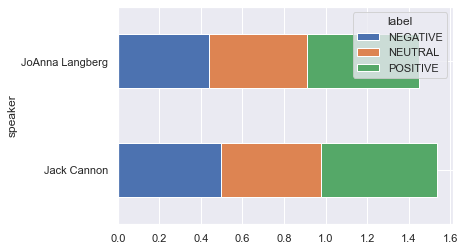

In [64]:
data.groupby(['speaker', 'label'], as_index=False) \
    .score \
    .mean() \
    .pivot(index=['speaker'], columns='label', values='score') \
    .plot \
    .barh(stacked=True)

In [126]:
data.groupby(['speaker', 'label'], as_index=False) \
    .score \
    .mean()

,speaker,label,score
0,Jack Cannon,NEGATIVE,0.337639
1,Jack Cannon,NEUTRAL,0.191004
2,Jack Cannon,POSITIVE,0.471357
3,JoAnna Langberg,NEGATIVE,0.313063
4,JoAnna Langberg,NEUTRAL,0.240922
5,JoAnna Langberg,POSITIVE,0.446015


In [115]:
sentiment_df.set_index('idx')

,seq,model,granularity,label,score
idx,,,,,
0,"Okay, so I think this may not take very long,...",facebook/bart-large-mnli,binary,POSITIVE,0.767311
0,"Okay, so I think this may not take very long,...",facebook/bart-large-mnli,binary,NEUTRAL,0.146793
0,"Okay, so I think this may not take very long,...",facebook/bart-large-mnli,binary,NEGATIVE,0.085896
1,"So I am getting some results, and I just kind...",facebook/bart-large-mnli,binary,NEGATIVE,0.453215
1,"So I am getting some results, and I just kind...",facebook/bart-large-mnli,binary,POSITIVE,0.405376
...,...,...,...,...,...
961,"Okay, do you think it's gonna be like a minute.",facebook/bart-large-mnli,binary,NEGATIVE,0.282832
961,"Okay, do you think it's gonna be like a minute.",facebook/bart-large-mnli,binary,POSITIVE,0.249464
962,or an hour a minute or two.,facebook/bart-large-mnli,binary,NEGATIVE,0.459970


In [112]:
data

,meeting_id,speaker,seq,model,granularity,label,score
129,82231180743,Jack Cannon,yeah so there was a setting that.,facebook/bart-large-mnli,binary,POSITIVE,0.891777
129,82231180743,Jack Cannon,yeah so there was a setting that.,facebook/bart-large-mnli,binary,NEGATIVE,0.069164
129,82231180743,Jack Cannon,yeah so there was a setting that.,facebook/bart-large-mnli,binary,NEUTRAL,0.039059
130,82231180743,None,Was the disabled.,facebook/bart-large-mnli,binary,NEUTRAL,0.641247
130,82231180743,None,Was the disabled.,facebook/bart-large-mnli,binary,NEGATIVE,0.217548
...,...,...,...,...,...,...,...
180,82231180743,Jack Cannon,whiteboard session so.,facebook/bart-large-mnli,binary,NEUTRAL,0.387033
180,82231180743,Jack Cannon,whiteboard session so.,facebook/bart-large-mnli,binary,NEGATIVE,0.077676
181,82231180743,Jack Cannon,we'll stop recording.,facebook/bart-large-mnli,binary,NEGATIVE,0.383032
181,82231180743,Jack Cannon,we'll stop recording.,facebook/bart-large-mnli,binary,POSITIVE,0.382655
